# 3D Shape Retrieval Project, Giuseppe Ricciardi
The goal of this student project is to implement a 3D shape retrieval system using view-based descriptors. The project will involve the use of the trimesh library for handling 3D mesh data  and PyTorch for building and training a neural network model for shape retrieval

First of all we import all the libraries here:

In [2]:
import os
import sys
sys.path.append("./")
import gzip
import io
import trimesh
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
import math
from custom_dataset import ImageFolderWithPaths
from collate import custom_collate

### Data Collection
The dataset chosen is the McGill datases, it comprends 10 classes of different 3D Models with articulating parts. <br/>
 The mesh representations (.ply) correspond to the boundary voxels of the corresponding voxel representations.<br/>
Each class (label) have a different number of subjects.

The following class is used to handle the dataset. <br/>
The dataset is initialized with the root directory, file type (defaulting to 'ply'), and an optional seed for shuffling. It efficiently loads and organizes 3D mesh samples, each associated with a category label and data path. Leveraging the PyTorch Dataset class, it allows easy access to individual samples, their lengths, and 3D meshes through __getitem__, __len__, and get_mesh methods, respectively. <br/>
The class further provides functionality to generate 2D views from 3D shapes, allowing rotation around X, Y, and Z axes. With robust error handling and the integration of trimesh and PIL libraries.

In [5]:
class McGillDataset3D(Dataset):
    def __init__(self, root_dir: str, file_type: str = 'ply', seed=42):
        """
        Custom dataset for McGill dataset.

        Parameters:
        - root_dir (str): Root directory of the dataset.
        - file_type (str, optional): Type of file to load data from. Defaults to 'ply'.
        - seed (int, optional): Seed for shuffling. Defaults to None.
        """
        self.root_dir = root_dir
        self.file_type = file_type

        # List all the categories (subdirectories) in the root directory
        self.categories = os.listdir(root_dir)

        # Create a dictionary to map category names to their respective subdirectories
        self.category_paths = {category: os.path.join(root_dir, category) for category in self.categories}

        self.all_data_paths = self.get_all_data_paths()

        random.seed(seed)
        random.shuffle(self.all_data_paths)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.all_data_paths)

    def __getitem__(self, idx):
        """
        Returns a sample from the dataset.

        Parameters:
        - idx (int): Index of the sample.

        Returns:
        - sample (dict): A dictionary containing 'data' (3D mesh) and 'label' (category name).
        """
        # Load the data (3D mesh) using the appropriate method
        data_path = self.all_data_paths[idx]
        category = self.get_category_from_path(data_path)

        if self.file_type == 'Im':
            with gzip.open(data_path, 'rb') as f:
                data = Image.open(io.BytesIO(f.read()))
        elif self.file_type == 'Ply':
            if data_path.endswith('.gz'):
                with gzip.open(data_path, 'rb') as f:
                    file_extension = os.path.splitext(data_path[:-3])[1]
                    data = trimesh.load(file_obj=io.BytesIO(f.read()), file_type=file_extension, process=False)
            else:
                file_extension = os.path.splitext(data_path)[1]
                data = trimesh.load(data_path, file_type=file_extension, process=False)


        # Prepare the sample dictionary
        sample = {'data': data, 'label': category, 'path': data_path}

        return sample

    def get_category_from_path(self, data_path):
        """
        Extract category name from the data path.

        Parameters:
        - data_path (str): Full path to the data file.

        Returns:
        - category (str): Category name.
        """
        # Extract category name from the path
        category = os.path.basename(os.path.dirname(os.path.dirname(data_path)))
        return category


    def get_all_data_paths(self):
        """
        Return a list of all data paths in the dataset.
        """
        all_paths = []
        for category in self.categories:
            category_path = self.category_paths[category]
            data_paths = os.listdir(os.path.join(category_path, f'{category}{self.file_type}'))
            full_paths = [os.path.join(category_path, f'{category}{self.file_type}', data_name) for data_name in data_paths]
            all_paths.extend(full_paths)
        return all_paths

    def get_mesh(self, idx):
        """
        Return the 3D mesh.

        Parameters:
        - idx (int): Index of the sample.
        """
        return self.__getitem__(idx)['data']


    def generate_2d_views(self, idx, num_steps_x=5, num_steps_y=5, resolution=(256, 256)):
        """
        Generate 2D views from a 3D shape by rotating around both X and Y axes.

        Parameters:
        - idx (int): Index of the 3D shape in the dataset.
        - num_steps_x (int, optional): Number of steps in rotation around the X axis. Defaults to 5.
        - num_steps_y (int, optional): Number of steps in rotation around the Y axis. Defaults to 5.
        - resolution (tuple, optional): Resolution of the generated images. Defaults to (256, 256).

        Returns:
        - views (list): List of PIL Image objects representing 2D views.
        """
        # Load the data (3D mesh) using the existing __getitem__ method
        sample = self.__getitem__(idx)

        mesh = sample['data']

        # Create a scene with the mesh
        scene = mesh.scene()

        # Initialize a list to store generated views
        views = []

        # Calculate step sizes for rotation
        step_size_x = 360 / num_steps_x
        step_size_y = 180 / num_steps_y

        # Iterate through rotation angles
        for angle_x in range(0, 360, int(step_size_x)):
            for angle_y in range(-90, 90, int(step_size_y)):
                # Rotation matrix around the X-axis
                rotate_x = trimesh.transformations.rotation_matrix(
                    angle=np.radians(angle_x), direction=[1, 0, 0], point=scene.centroid)

                # Rotation matrix around the Y-axis
                rotate_y = trimesh.transformations.rotation_matrix(
                    angle=np.radians(angle_y), direction=[0, 1, 0], point=scene.centroid)

                # Combine the rotations
                rotate_combined = trimesh.transformations.concatenate_matrices(rotate_x, rotate_y)

                # Apply the combined transform to the camera view transform
                camera_old, _geometry = scene.graph[scene.camera.name]
                camera_new = np.dot(rotate_combined, camera_old)
                scene.graph[scene.camera.name] = camera_new

                # Render the scene and save the image
                try:
                    # Save a render of the object as a PNG

                    png = scene.save_image(resolution=resolution, visible=False)

                    # Convert the PNG to a PIL Image
                    image = Image.open(io.BytesIO(png))

                    # Append the image to the views list
                    views.append(image)
                except BaseException as e:
                    print(f"Unable to save image: {str(e)}")

        return views, sample

    def generate_2d_views_single_rotation(self, idx, num_steps=5, resolution=(256, 256)):
        """
        Generate 2D views from a 3D shape by rotating around the Z axis.

        Parameters:
        - idx (int): Index of the 3D shape in the dataset.
        - num_steps (int, optional): Number of steps in rotation around the Z axis. Defaults to 5.
        - resolution (tuple, optional): Resolution of the generated images. Defaults to (256, 256).

        Returns:
        - views (list): List of PIL Image objects representing 2D views.
        """
        # Load the data (3D mesh) using the existing __getitem__ method
        sample = self.__getitem__(idx)

        mesh = sample['data']

        # Create a scene with the mesh
        scene = mesh.scene()

        # Initialize a list to store generated views
        views = []

        # Calculate step size for rotation around the Z axis
        step_size_z = 360 / num_steps

        # Iterate through rotation angles around the Z axis
        for angle_z in range(0, 360, int(step_size_z)):
            # Rotation matrix around the Z-axis
            rotate_z = trimesh.transformations.rotation_matrix(
                angle=np.radians(angle_z), direction=[0, 1, 0], point=scene.centroid)

            # Apply the rotation transform to the camera view transform
            camera_old, _geometry = scene.graph[scene.camera.name]
            camera_new = np.dot(rotate_z, camera_old)
            scene.graph[scene.camera.name] = camera_new

            # Render the scene and save the image
            try:
                # Save a render of the object as a PNG
                png = scene.save_image(resolution=resolution, visible=False)

                # Convert the PNG to a PIL Image
                image = Image.open(io.BytesIO(png))

                # Append the image to the views list
                views.append(image)
            except BaseException as e:
                print(f"Unable to save image: {str(e)}")

        return views, sample

In [4]:
root_dir = '../data'
# Create an instance of the McGillDataset class for Ply files
dataset = McGillDataset3D(root_dir, file_type='Ply')

In [8]:
# Display a sample (change the index as needed)
dataset[8]

{'data': <trimesh.Trimesh(vertices.shape=(7532, 3), faces.shape=(152988, 3), name=`.ply`)>,
 'label': 'humans',
 'path': '../data/humans/humansPly/b16.ply'}

In [7]:
dataset[8]['data'].show()

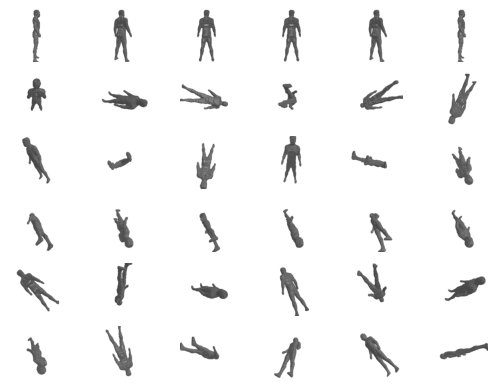

In [25]:
idx = 8
num_steps_x = 6
num_steps_y = 6
views, sample_data = dataset.generate_2d_views(idx, num_steps_x, num_steps_y)

# Display the generated views
for i, view in enumerate(views):
    plt.subplot(num_steps_x, num_steps_y, i + 1)
    plt.imshow(view)
    plt.axis('off')

plt.show()

The process_dataset function takes a 3D mesh dataset, generates 2D views for each 3D shape in the dataset by rotating it along both the X and Y axes, and saves the resulting 2D views as PNG images. It iterates through each sample in the dataset using the tqdm library for progress tracking. <br/>
For each sample, it extracts relevant information such as the sample's path, category label, and the base directory. It then creates a subdirectory named "Image2D" within the "./2D_dataset" directory, specific to the category and 3D shape. The function utilizes the generate_2d_views method from the provided dataset class to obtain a list of 2D views. Each view is saved as a PNG image in the corresponding subdirectory, with filenames indicating the original shape, view index, and PNG extension

In [3]:
def process_dataset(dataset, num_steps_x=6, num_steps_y=6):
    """
    Process a dataset, generate 2D views, and save them to the corresponding directories.

    Parameters:
    - dataset: The dataset to process.
    - num_steps_x: The number of steps along the x-axis for generating 2D views.
    - num_steps_y: The number of steps along the y-axis for generating 2D views.
    """

    for i in tqdm(range(len(dataset)), desc="Processing dataset"):
        sample = dataset[i]

        # Extract the relevant part of the path
        path = sample['path']
        category = sample['label']
        base_path = os.path.join(dataset.root_dir, category)

        # Create the Image2D subdirectory if it doesn't exist
        file_name_without_extension = os.path.splitext(os.path.basename(path))[0]
        file_name_without_extension = os.path.splitext(os.path.basename(file_name_without_extension))[0]
        image2d_subdir = os.path.join("./2D_dataset", f'{category}Image2D', file_name_without_extension)
        os.makedirs(image2d_subdir, exist_ok=True)

        views, sample_data = dataset.generate_2d_views(i, num_steps_x, num_steps_y)

        # Save the images in the image2d_subdir
        for idx, image in enumerate(views):
            image_filename = f"{file_name_without_extension}_view_{idx + 1}.png"
            image_path = os.path.join(image2d_subdir, image_filename)
            image.save(image_path)
        print(f"{image_path} successfully saved ")

In [ ]:
process_dataset(dataset)

## Data Splitting
The dataset composed by the retrieved 2D images has been splitted in:
- 60% training set
- 20% validation set
- 20% test set

Each image is resized to 64x64 for reduce the time complexity of the model.


In [3]:
dataset_path = './2D_dataset'

#Defining the dataloaders of the balanced set
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),
])
# Create the ImageFolder dataset with paths
dataset = ImageFolderWithPaths(root=dataset_path, transform= transform)

# Calculate the sizes of training, validation, and test sets
total_samples = len(dataset)
train_size = int(0.6 * total_samples)  # 60% for training
val_size = int(0.2 * total_samples)    # 20% for validation
test_size = total_samples - train_size - val_size

# Split the dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

#Print the labels of the dataset
print(dataset.classes)

#Print paths of the dataset
print(dataset)


['ants', 'crabs', 'hands', 'humans', 'octopuses', 'pliers', 'snakes', 'spectacles', 'spiders', 'teddy']
Dataset ImageFolderWithPaths
    Number of datapoints: 9180
    Root location: ./2D_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


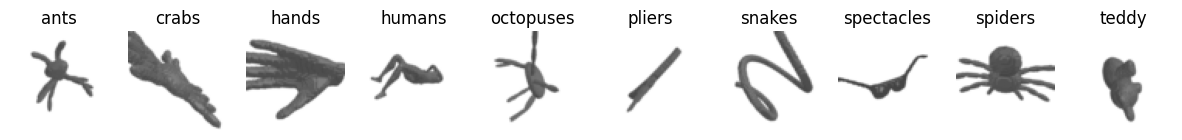

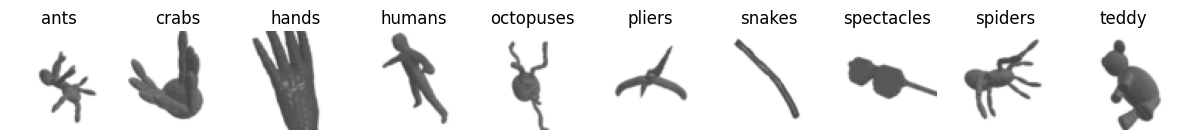

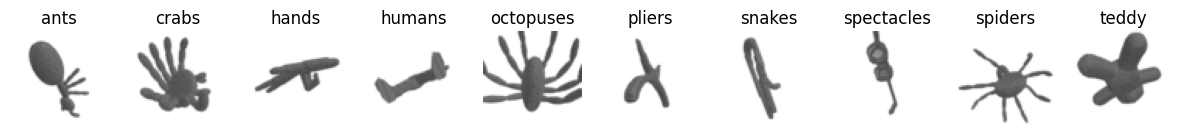

In [5]:
# Function to plot an image for each category in a given data loader
def plot_images(data_loader, dataset):
    # Get the class names from the dataset
    class_names = dataset.classes

    # Create a figure with subplots for each category
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 2))

    # Iterate over each category
    for i, class_name in enumerate(class_names):
        # Find the index of the first sample in the data loader belonging to the current category
        sample_index = next(idx for idx, (image, label, path) in enumerate(data_loader.dataset) if label == i)
        
        # Get the image and label
        image, label, path = data_loader.dataset[sample_index]
        #Permute image dimensions 
        image = image.permute(1, 2, 0)
        # Plot the image
        axs[i].imshow(image)
        axs[i].set_title(class_name)
        axs[i].axis('off')

    plt.show()

# Plot images for each category in the training set
plot_images(train_loader, dataset)

# Plot images for each category in the validation set
plot_images(val_loader, dataset)

# Plot images for each category in the test set
plot_images(test_loader, dataset)



In [6]:
#Check if the dataset is balanced, count the number of samples in each class for each set
def print_class_distribution(dataset, name):
    try:
        classes = getattr(dataset.dataset, 'classes', None)
        if classes is None:
            classes = getattr(dataset, 'classes', None)
        if classes is None:
            # If neither dataset.dataset nor dataset has 'classes', try to infer it from the dataset
            classes = list(set(label for _, label, path in dataset))

    except Exception:
        raise ValueError("Unable to determine 'classes' attribute from the dataset.")

    class_counts = [0] * len(classes)
    for _, label, path in dataset:
        class_counts[label] += 1

    print(f"{name} set class distribution:")
    for i, count in enumerate(class_counts):
        print(f"Class '{classes[i]}': {count} samples")


In [7]:

# Print class distribution for each set of original dataset
print_class_distribution(train_set, "Training")
print("\n")
print_class_distribution(val_set, "Validation")
print("\n")
print_class_distribution(test_set, "Test")

Training set class distribution:
Class 'ants': 653 samples
Class 'crabs': 633 samples
Class 'hands': 412 samples
Class 'humans': 614 samples
Class 'octopuses': 566 samples
Class 'pliers': 424 samples
Class 'snakes': 543 samples
Class 'spectacles': 540 samples
Class 'spiders': 677 samples
Class 'teddy': 446 samples


Validation set class distribution:
Class 'ants': 209 samples
Class 'crabs': 222 samples
Class 'hands': 166 samples
Class 'humans': 213 samples
Class 'octopuses': 174 samples
Class 'pliers': 153 samples
Class 'snakes': 180 samples
Class 'spectacles': 170 samples
Class 'spiders': 208 samples
Class 'teddy': 141 samples


Test set class distribution:
Class 'ants': 218 samples
Class 'crabs': 225 samples
Class 'hands': 142 samples
Class 'humans': 217 samples
Class 'octopuses': 160 samples
Class 'pliers': 143 samples
Class 'snakes': 177 samples
Class 'spectacles': 190 samples
Class 'spiders': 231 samples
Class 'teddy': 133 samples


As we can see the dataset seems be quite unbalanced, this can lead to problems for the training of the classifier. To solve this problem we will:
- Identify the class with the minimum number of samples.
- Use that minimum number to randomly sample an equal number of samples from each class.
- Create a new balanced dataset using the sampled images.

In [4]:
# Calculate the minimum number of samples across all classes
min_samples = min([dataset.targets.count(class_idx) for class_idx in range(len(dataset.classes))])

# Create a balanced dataset by sampling an equal number of samples from each class
balanced_samples = []
for class_idx in range(len(dataset.classes)):
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    random_indices = random.sample(class_indices, min_samples)
    balanced_samples.extend(random_indices)

# Create a new balanced dataset using the sampled indices
balanced_dataset = torch.utils.data.Subset(dataset, balanced_samples)

# Calculate the sizes of training, validation, and test sets for the balanced dataset
total_balanced_samples = len(balanced_dataset)
train_balanced_size = int(0.6 * total_balanced_samples)
val_balanced_size = int(0.2 * total_balanced_samples)
test_balanced_size = total_balanced_samples - train_balanced_size - val_balanced_size

# Split the balanced dataset
train_balanced_set, val_balanced_set, test_balanced_set = random_split(balanced_dataset, [train_balanced_size, val_balanced_size, test_balanced_size])


In [7]:

# Print class distribution for each set in the balanced dataset
print_class_distribution(train_balanced_set, "Balanced Training")
print_class_distribution(val_balanced_set, "Balanced Validation")
print_class_distribution(test_balanced_set, "Balanced Test")


Balanced Training set class distribution:
Class '0': 443 samples
Class '1': 423 samples
Class '2': 411 samples
Class '3': 421 samples
Class '4': 431 samples
Class '5': 432 samples
Class '6': 422 samples
Class '7': 457 samples
Class '8': 440 samples
Class '9': 440 samples
Balanced Validation set class distribution:
Class '0': 141 samples
Class '1': 157 samples
Class '2': 146 samples
Class '3': 133 samples
Class '4': 152 samples
Class '5': 136 samples
Class '6': 154 samples
Class '7': 137 samples
Class '8': 141 samples
Class '9': 143 samples
Balanced Test set class distribution:
Class '0': 136 samples
Class '1': 140 samples
Class '2': 163 samples
Class '3': 166 samples
Class '4': 137 samples
Class '5': 152 samples
Class '6': 144 samples
Class '7': 126 samples
Class '8': 139 samples
Class '9': 137 samples


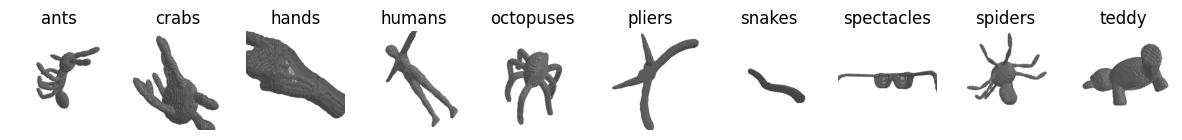

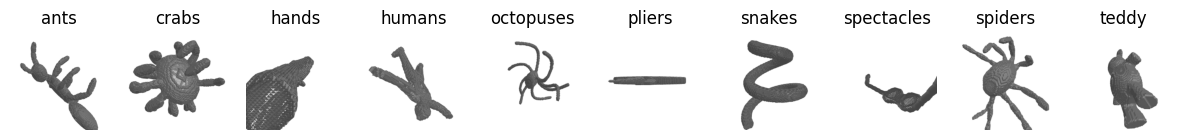

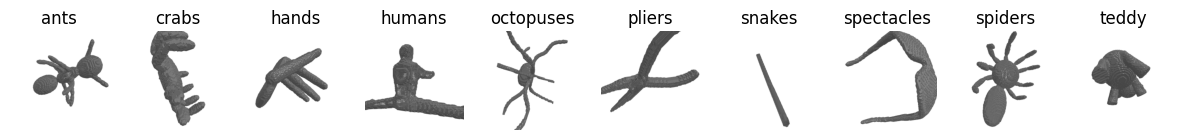

In [6]:
# Plot images for each category in the balanced training set
plot_images(DataLoader(train_balanced_set, batch_size=32, shuffle=True, num_workers=4), dataset)
# Plot images for each category in the balanced validation set
plot_images(DataLoader(val_balanced_set, batch_size=32, shuffle=False, num_workers=4), dataset)
# Plot images for each category in the balanced test set
plot_images(DataLoader(test_balanced_set, batch_size=32, shuffle=False, num_workers=4), dataset)

## Neural Network Model
The Neural Network model chosen for the task is **GoogleNet**.<br/>
The primary characteristic of GoogleNet is the use of inception modules, which are designed to capture features at different scales. The inception module employs a combination of convolutional filters with different receptive field sizes, allowing the network to simultaneously process information at multiple resolutions. This parallelization within a single layer facilitates the extraction of both fine and coarse-grained features. <br/>

The architecture of GoogleNet comprises multiple stacked inception modules, and the network itself is quite deep. To address the challenges associated with vanishing gradients in deep networks, GoogleNet introduces auxiliary classifiers at intermediate layers during training. These auxiliary classifiers provide additional supervision signals, aiding in the training process and encouraging the flow of gradients through the network.<br/>

Moreover, GoogleNet incorporates global average pooling instead of fully connected layers at the end of the network, reducing the number of parameters and mitigating overfitting. The use of 1x1 convolutions is another notable aspect, helping to control the dimensionality of the network and improving computational efficiency.



In [6]:
class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super().__init__()

        #1x1conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 3x3conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 5x5conv branch
        #we use 2 3x3 conv filters stacked instead
        #of 1 5x5 filters to obtain the same receptive
        #field with fewer parameters
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        #3x3pooling -> 1x1conv
        #same conv
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=10):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        #although we only use 1 conv layer as prelayer,
        #we still use name a3, b3.......
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        ##"""In general, an Inception network is a network consisting of
        ##modules of the above type stacked upon each other, with occasional
        ##max-pooling layers with stride 2 to halve the resolution of the
        ##grid"""
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        #"""It was found that a move from fully connected layers to
        #average pooling improved the top-1 accuracy by about 0.6%,
        #however the use of dropout remained essential even after
        #removing the fully connected layers."""
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

def googlenet():
    return GoogleNet()


## Training
In this section we train the GoogleNet using the training and validation set. After the training a plot of the loss curves are visualized for ensuring that the model is learning

In [9]:

train_balanced_loader = DataLoader(train_balanced_set, batch_size=32, shuffle=True, num_workers=4)
val_balanced_loader = DataLoader(val_balanced_set, batch_size=32, shuffle=False, num_workers=4)
test_balanced_loader = DataLoader(test_balanced_set, batch_size=32, shuffle=False, num_workers=4)

# Assuming you have defined your GoogleNet model
model = googlenet()

# Define loss function and optimizer
# For the loss function, we use CrossEntropyLoss which applies LogSoftmax + NLLLoss
criterion = nn.CrossEntropyLoss()
# For the optimizer, we use SGD with momentum (a variant of gradient descent) 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define the number of training epochs
num_epochs = 15
#Save Losses and Accuracies every epoch to plot them later 
train_losses = []
val_losses = []
model.train()  # Set the model to training mode
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels, path in tqdm(train_balanced_loader):  # Assuming you have a DataLoader for the training set
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        running_loss += loss.item()
    train_loss = running_loss / len(train_balanced_loader)
    train_losses.append(train_loss)
    with torch.no_grad():
        for inputs, labels, path in tqdm(val_balanced_loader): 
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute the loss
            running_loss += loss.item()
    validation_loss = running_loss / len(val_balanced_loader)
    val_losses.append(validation_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")
#Save the model
torch.save(model.state_dict(), 'googlenet.pth')

100%|██████████| 45/45 [01:21<00:00,  1.82s/it]


Epoch 1/15, Train Loss: 1.4058, Validation Loss: 5.2671


100%|██████████| 45/45 [01:17<00:00,  1.72s/it]


Epoch 2/15, Train Loss: 0.8531, Validation Loss: 3.3640


100%|██████████| 45/45 [01:17<00:00,  1.71s/it]


Epoch 3/15, Train Loss: 0.6476, Validation Loss: 2.7256


100%|██████████| 45/45 [01:16<00:00,  1.71s/it]


Epoch 4/15, Train Loss: 0.5570, Validation Loss: 2.3427


100%|██████████| 45/45 [01:17<00:00,  1.72s/it]


Epoch 5/15, Train Loss: 0.4724, Validation Loss: 1.9930


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 6/15, Train Loss: 0.3876, Validation Loss: 1.7090


100%|██████████| 45/45 [01:19<00:00,  1.76s/it]


Epoch 7/15, Train Loss: 0.3274, Validation Loss: 1.4272


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 8/15, Train Loss: 0.3003, Validation Loss: 1.4657


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 9/15, Train Loss: 0.2514, Validation Loss: 1.0670


100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


Epoch 10/15, Train Loss: 0.1824, Validation Loss: 0.9475


100%|██████████| 45/45 [03:30<00:00,  4.68s/it]


Epoch 11/15, Train Loss: 0.1783, Validation Loss: 0.9227


100%|██████████| 45/45 [01:22<00:00,  1.83s/it]


Epoch 12/15, Train Loss: 0.1487, Validation Loss: 0.8354


100%|██████████| 45/45 [01:19<00:00,  1.76s/it]


Epoch 13/15, Train Loss: 0.1180, Validation Loss: 0.7613


100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


Epoch 14/15, Train Loss: 0.1361, Validation Loss: 0.7875


100%|██████████| 45/45 [01:19<00:00,  1.78s/it]

Epoch 15/15, Train Loss: 0.1337, Validation Loss: 0.7527


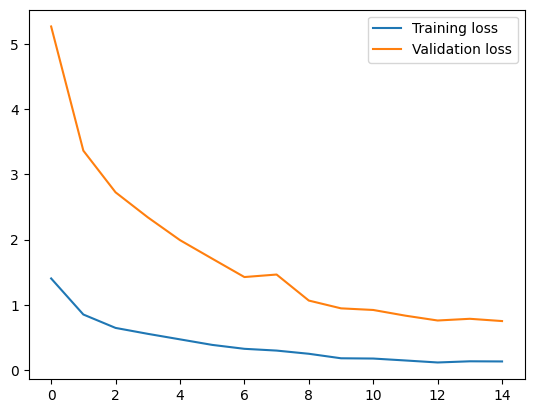

In [10]:
#Print the loss curves of the training and validation sets
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

The training process spans 15 epochs, with each epoch comprising iterations over the entire training dataset.<br/>
The model exhibits a descending trend in both training and validation losses, indicating a gradual improvement in its ability to generalize to unseen data. Notably, the training loss consistently decreases, demonstrating the model's proficiency in fitting the training data.<br/> Simultaneously, the validation loss, which gauges the model's performance on previously unseen validation data, also diminishes. <br/>
This convergence between training and validation losses suggests that the model is effectively learning relevant features from the training set without overfitting. 

## Evaluation
In this section, the trained model undergoes evaluation on the test set. Subsequently, feature vectors are extracted from both the training and test sets. The objective is to retrieve images by identifying the top three neighbors of a test feature vector from the training feature vectors.

In [8]:

train_balanced_loader = DataLoader(train_balanced_set, batch_size=32, shuffle=True, num_workers=4)
val_balanced_loader = DataLoader(val_balanced_set, batch_size=32, shuffle=False, num_workers=4)
test_balanced_loader = DataLoader(test_balanced_set, batch_size=32, shuffle=False, num_workers=4)
# Load the model
model = googlenet()
model.load_state_dict(torch.load('googlenet.pth'))
#Test the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, path in tqdm(test_balanced_loader): 
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
print(f"Test Accuracy: {100 * correct / total}%")

#Print the classification report
print(classification_report(y_true, y_pred))


100%|██████████| 45/45 [01:17<00:00,  1.73s/it]

Test Accuracy: 94.72222222222223%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       131
           1       0.98      0.91      0.94       159
           2       0.89      0.98      0.93       143
           3       0.93      0.90      0.92       154
           4       0.95      0.91      0.93       158
           5       0.96      0.99      0.98       148
           6       0.97      0.91      0.94       127
           7       0.95      0.98      0.96       131
           8       0.95      0.92      0.93       151
           9       0.97      1.00      0.99       138

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



The GoogleNet model exhibits strong performance on the testing set, achieving an overall accuracy of 94.72%. The precision, recall, and F1-score metrics further illustrate the model's effectiveness in classifying different categories. Notably, the model demonstrates high precision and recall values for most classes, reflecting its ability to correctly identify instances within each category. The weighted average F1-score of 95% underscores the model's robustness across various classes, contributing to an overall reliable classification performance on the dataset.

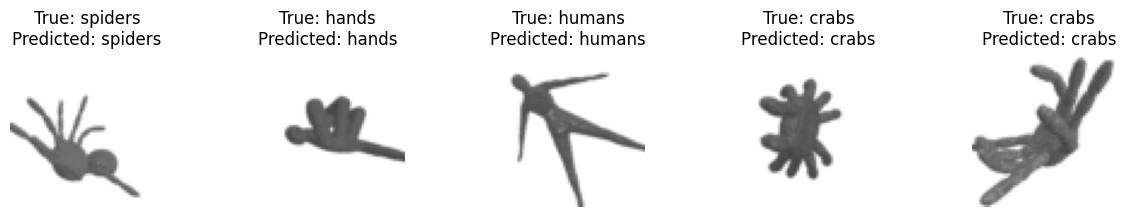

In [17]:
#Print some images with their predicted and true labels
class_names = dataset.classes
num_samples = 5
samples = random.sample(range(len(test_balanced_set)), num_samples)
fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
for i, sample in enumerate(samples):
    image, label, path = test_balanced_set[sample]
    image = np.transpose(image.numpy(), (1, 2, 0))
    axs[i].imshow(image)
    axs[i].set_title(f"True: {class_names[label]}\nPredicted: {class_names[y_pred[sample]]}")
    axs[i].axis('off')
plt.show()


The extract_features function efficiently derives feature vectors from a PyTorch dataloader using a pre-trained neural network model. Operating in a batch-wise manner, it performs forward passes to generate predictions, extracting feature vectors, labels, and image paths for each sample. The results are organized into a dictionary, where feature vectors are grouped by their corresponding labels.

In [21]:
#Function to extract features:
def extract_features(dataloader):
    features_by_label = {} # Dictionary to store all the features vectors and their image path organized by label 
    with torch.no_grad():
        for inputs, labels, paths in tqdm(dataloader):
            outputs = model(inputs)
            for i in range(len(labels)):
                label = int(labels[i].item())
                feature_vector = outputs[i].numpy()
                path = paths[i]

                if label not in features_by_label:
                    features_by_label[label] = []

                features_by_label[label].append((feature_vector, path))

    return features_by_label

In [ ]:

# Extract features for training set
train_features_by_label = extract_features(train_balanced_loader)


In [27]:

# Print the shape of feature vectors for each class
for label, features in train_features_by_label.items():
    print(f"Class {label}: {features[0][1]}")


Class 8: ./2D_dataset/spiders/19/19_view_31.png
Class 1: ./2D_dataset/crabs/14/14_view_19.png
Class 9: ./2D_dataset/teddy/b19/b19_view_27.png
Class 2: ./2D_dataset/hands/b11/b11_view_14.png
Class 5: ./2D_dataset/pliers/b13/b13_view_32.png
Class 3: ./2D_dataset/humans/b16/b16_view_33.png
Class 4: ./2D_dataset/octopuses/10/10_view_5.png
Class 7: ./2D_dataset/spectacles/b19/b19_view_16.png
Class 0: ./2D_dataset/ants/2/2_view_11.png
Class 6: ./2D_dataset/snakes/18/18_view_19.png


In [28]:
#Extract features for test set
test_features_by_label = extract_features(test_balanced_loader)

100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


In [30]:
# Print labels and paths of the first retrieved image for demonstration
label = next(iter(test_features_by_label))
features, path = test_features_by_label[label][0]
print(f"Label: {label}, Path: {path}")

Label: 3, Path: ./2D_dataset/humans/b2/b2_view_16.png


In [67]:
def load_image(label, path):
    image = plt.imread(path)  # Load the image using Matplotlib
    return image, label

def plot_test_and_neighbors(test_feature, test_label, test_path, neighbor_features, neighbor_labels, neighbor_paths):
    # Load images for the test sample and its nearest neighbors
    test_image, _ = load_image(test_label, test_path)
    neighbor_images = [load_image(neighbor_label, neighbor_path)[0] for neighbor_label, neighbor_path in zip(neighbor_labels, neighbor_paths)]

    # Print information about the test sample and its nearest neighbors
    print("Test Sample:")
    print(f"True Label: {test_label}")
    print(f"True Path: {test_path}")
    print(f"Nearest Neighbors:")
    for i, neighbor_label in enumerate(neighbor_labels):
        print(f"Neighbor {i + 1}: Predicted Label - {neighbor_label}, Predicted Path - {neighbor_paths[i]}")

    # Plot the images
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_image)
    plt.title("Test Sample")
    plt.axis('off')

    for i, neighbor_image in enumerate(neighbor_images):
        plt.subplot(2, 2, i + 2)
        plt.imshow(neighbor_image)
        plt.title(f"Neighbor {i + 1}")
        plt.axis('off')

    plt.show()


For the image retrieval a **k-Nearest Neighbors (k-NN)** model is utilized for nearest neighbor analysis. Initially, dictionaries containing training and testing features, organized by labels, are converted into lists of tuples. Labels, features, and paths are then extracted from these tuples and converted into NumPy arrays. The model is trained using the features from the training set, and subsequently, the nearest neighbors for each vector in the test set are identified based on Euclidean distances. <br/>
The accuracy of the model is computed by comparing the labels of the nearest neighbors with the actual test labels, providing an assessment of the model's performance. <br/>
The visualization section randomly selects test samples and displays their respective nearest neighbors using the plot_test_and_neighbors function.

Accuracy: 94.72%
Test Sample:
True Label: 3
True Path: ./2D_dataset/humans/b8/b8_view_17.png
Nearest Neighbors:
Neighbor 1: Predicted Label - 3, Predicted Path - ./2D_dataset/humans/b8/b8_view_9.png
Neighbor 2: Predicted Label - 3, Predicted Path - ./2D_dataset/humans/b10/b10_view_5.png
Neighbor 3: Predicted Label - 3, Predicted Path - ./2D_dataset/humans/b2/b2_view_28.png


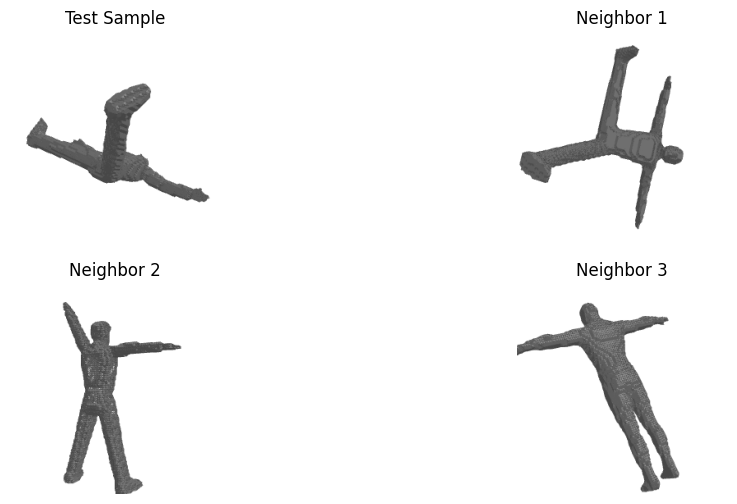

Test Sample:
True Label: 6
True Path: ./2D_dataset/snakes/2/2_view_22.png
Nearest Neighbors:
Neighbor 1: Predicted Label - 6, Predicted Path - ./2D_dataset/snakes/30/30_view_21.png
Neighbor 2: Predicted Label - 6, Predicted Path - ./2D_dataset/snakes/30/30_view_17.png
Neighbor 3: Predicted Label - 6, Predicted Path - ./2D_dataset/snakes/2/2_view_23.png


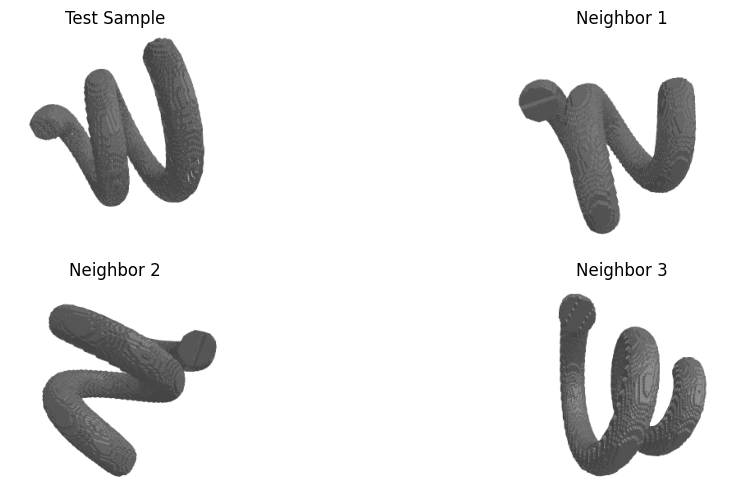

Test Sample:
True Label: 4
True Path: ./2D_dataset/octopuses/63/63_view_25.png
Nearest Neighbors:
Neighbor 1: Predicted Label - 4, Predicted Path - ./2D_dataset/octopuses/67/67_view_2.png
Neighbor 2: Predicted Label - 4, Predicted Path - ./2D_dataset/octopuses/67/67_view_5.png
Neighbor 3: Predicted Label - 4, Predicted Path - ./2D_dataset/octopuses/67/67_view_4.png


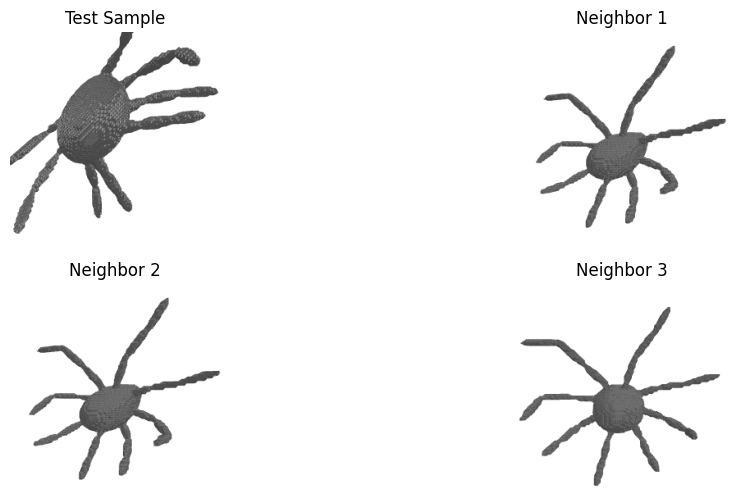

Test Sample:
True Label: 5
True Path: ./2D_dataset/pliers/b11/b11_view_24.png
Nearest Neighbors:
Neighbor 1: Predicted Label - 5, Predicted Path - ./2D_dataset/pliers/b8/b8_view_23.png
Neighbor 2: Predicted Label - 5, Predicted Path - ./2D_dataset/pliers/b2/b2_view_11.png
Neighbor 3: Predicted Label - 5, Predicted Path - ./2D_dataset/pliers/b6/b6_view_4.png


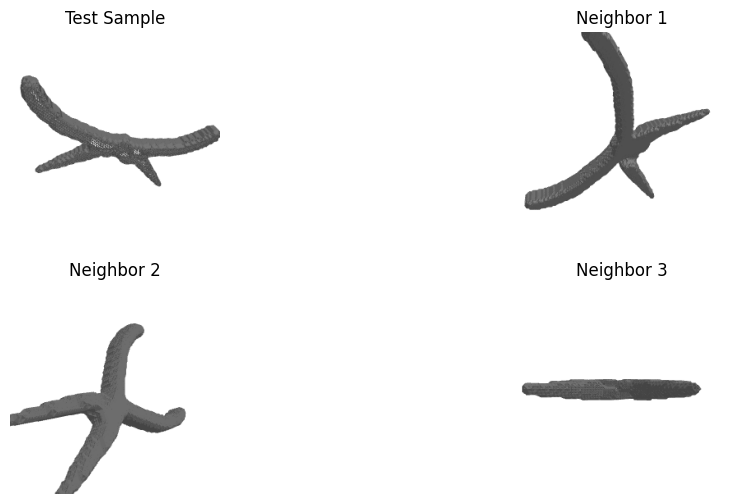

Test Sample:
True Label: 4
True Path: ./2D_dataset/octopuses/27/27_view_25.png
Nearest Neighbors:
Neighbor 1: Predicted Label - 4, Predicted Path - ./2D_dataset/octopuses/27/27_view_4.png
Neighbor 2: Predicted Label - 4, Predicted Path - ./2D_dataset/octopuses/29/29_view_18.png
Neighbor 3: Predicted Label - 8, Predicted Path - ./2D_dataset/spiders/29/29_view_8.png


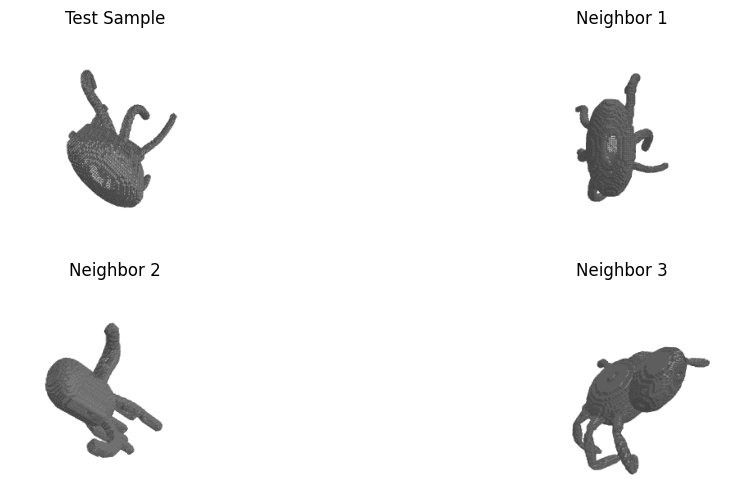

In [69]:
# Convert dictionaries to lists of tuples
train_data = [(label, feature, path) for label, features in train_features_by_label.items() for feature, path in features]
test_data = [(label, feature, path) for label, features in test_features_by_label.items() for feature, path in features]

# Extract features, labels, and paths
train_labels, train_features, train_paths = zip(*train_data)
test_labels, test_features, test_paths = zip(*test_data)

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
train_features = np.array(train_features)
train_paths = np.array(train_paths)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_paths = np.array(test_paths)

# Create a NearestNeighbors model
k = 3  # Number of neighbors to find
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(train_features)

# Find the nearest neighbors for each vector in the test set
# Distances are Euclidean distances between feature vectors
# Indices are the index of the feature vector with the smallest distance in the train set
distances, indices = neigh.kneighbors(test_features)

# For each vector in the test set, get the labels and paths of the nearest neighbors
nearest_neighbor_labels = train_labels[indices]
nearest_neighbor_paths = train_paths[indices]

# Calculate the accuracy
accuracy = np.sum(nearest_neighbor_labels[:, 0] == test_labels) / len(test_labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

num_visualizations = 5
for i in range(num_visualizations):
    # Get a random test sample index
    random_test_index = random.randint(0, len(test_features) - 1)
    nearest_neighbor_indices = indices[random_test_index]
    
    # Get the features, labels, and paths for the test sample and its nearest neighbors
    test_feature, test_path = test_features[random_test_index], test_paths[random_test_index]
    neighbor_features = train_features[nearest_neighbor_indices]
    neighbor_labels = train_labels[nearest_neighbor_indices]
    neighbor_paths = train_paths[nearest_neighbor_indices]

    # Plot the test sample and its nearest neighbors
    plot_test_and_neighbors(test_feature, test_labels[random_test_index], test_path, neighbor_features, neighbor_labels, neighbor_paths)
